In [1]:
from typing import Dict, TypedDict, Optional
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# --------------------------
# Step 1: Graph State
# --------------------------
class GraphState(TypedDict):
    vehicle_number: Optional[str]
    inoperative: Optional[str]
    location: Optional[str]
    vehicle_owner: Optional[str]
    insurance_number: Optional[str]
    response: Optional[str]

# --------------------------
# Dummy Vehicle DB
# --------------------------
vehicle_db = {
    "KA01AB1234": {"owner": "Shajee", "insurance": "INS123456"},
    "KA02CD5678": {"owner": "Anand", "insurance": "INS987654"},
}

# --------------------------
# Step 2: Create Workflow
# --------------------------
workflow = StateGraph(GraphState)

# --------------------------
# Node 1: Vehicle Verification
# --------------------------
def verify_vehicle_node(state):
    vehicle_num = state.get("vehicle_number", "").upper()
    if vehicle_num in vehicle_db:
        info = vehicle_db[vehicle_num]
        return {
            "vehicle_owner": info["owner"],
            "insurance_number": info["insurance"],
            "response": f"Vehicle {vehicle_num} verified. Owner: {info['owner']}, Insurance: {info['insurance']}"
        }
    else:
        # Ask insurance opt-in; for simplicity, assume user accepts
        return {
            "vehicle_owner": None,
            "insurance_number": None,
            "response": f"Vehicle {vehicle_num} not found. Insurance opt-in accepted. Proceeding..."
        }

# --------------------------
# Node 2: Normalize inoperative input
# --------------------------
def svrt_input_node(state):
    return {"inoperative": state.get("inoperative", "").strip().lower()}

# --------------------------
# Node 3: Inoperative = Yes
# --------------------------
def handle_police_ambulance_service_agent_node(state):
    loc = state.get("location", "Unknown")
    return {"response": f"Fatal & serious condition at {loc}. Arrange call to police, ambulance & service agent."}

# --------------------------
# Node 4: Inoperative = No
# --------------------------
def handle_service_agent_node(state):
    loc = state.get("location", "Unknown")
    return {"response": f"Fatal but manageable condition at {loc}. Arrange call to service agent only."}

# --------------------------
# Node 5: Inoperative unknown
# --------------------------
def handle_movable_node(state):
    inop = state.get("inoperative", "Unknown")
    loc = state.get("location", "Unknown")
    return {"response": f"Condition unclear: inoperative='{inop}' at {loc}. Please arrange manual assessment."}

# --------------------------
# Step 3: Add Nodes
# --------------------------
workflow.add_node("verify_vehicle", verify_vehicle_node)
workflow.add_node("svrt_input", svrt_input_node)
workflow.add_node("handle_police_ambulance_service_agent_node", handle_police_ambulance_service_agent_node)
workflow.add_node("handle_service_agent_node", handle_service_agent_node)
workflow.add_node("handle_movable", handle_movable_node)

# --------------------------
# Step 4: Conditional Edges
# --------------------------

# Decide after vehicle verification
def decide_after_vehicle_verification(state):
    # Proceed to inoperative check
    return "svrt_input"

workflow.add_conditional_edges(
    "verify_vehicle",
    decide_after_vehicle_verification,
    {
        "svrt_input": "svrt_input"
    }
)

# Decide next node after inoperative input
def decide_next_node(state):
    inop = state.get("inoperative", "")
    if inop == "yes":
        return "handle_police_ambulance_service_agent_node"
    elif inop == "no":
        return "handle_service_agent_node"
    else:
        return "handle_movable"

workflow.add_conditional_edges(
    "svrt_input",
    decide_next_node,
    {
        "handle_police_ambulance_service_agent_node": "handle_police_ambulance_service_agent_node",
        "handle_service_agent_node": "handle_service_agent_node",
        "handle_movable": "handle_movable"
    }
)

# --------------------------
# Step 5: Set Entry & End
# --------------------------
workflow.set_entry_point("verify_vehicle")
workflow.add_edge("handle_police_ambulance_service_agent_node", END)
workflow.add_edge("handle_service_agent_node", END)
workflow.add_edge("handle_movable", END)
workflow.add_edge("svrt_input", END)

# --------------------------
# Step 6: Compile
# --------------------------
app = workflow.compile()

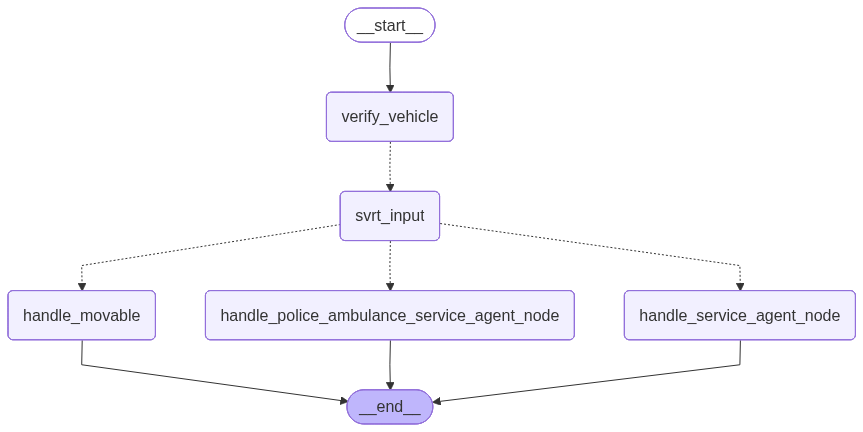

In [6]:

    display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
print(app.invoke({
    "vehicle_number": "KA01AB1234",
    "inoperative": "Yes",
    "location": "Koramangala"
}))




In [ ]:
# Vehicle exists, inoperative = No
print(app.invoke({
    "vehicle_number": "KA02CD5678",
    "inoperative": "No",
    "location": "Whitefield"
}))




In [ ]:
# Vehicle does not exist, inoperative = Maybe
print(
    app.invoke({
        "vehicle_number": "KA03EF9999",
        "inoperative": "Maybe",
        "location": "Indiranagar"
    }))